## Rotating Interface Problem

This example demonstrates density-driven groundwater flow.

### Initial setup

Import dependencies, define some variables, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-rotate"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)
gif_save = get_env("GIF", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nstp = 1000  # Number of time steps
perlen = 10000  # Simulation time length ($d$)
length = 300  # Length of box ($m$)
height = 40.0  # Height of box  ($m$)
nlay = 80  # Number of layers
nrow = 1  # Number of rows
ncol = 300  # Number of columns
system_length = 150.0  # Length of system ($m$)
delr = 1.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delv = 0.5  # Layer thickness
top = height / 2  # Top of the model ($m$)
hydraulic_conductivity = 2.0  # Hydraulic conductivity ($m d^{-1}$)
denseref = 1000.0  # Reference density
denseslp = 0.7  # Density and concentration slope
rho1 = 1000.0  # Density of zone 1 ($kg m^3$)
rho2 = 1012.5  # Density of zone 2 ($kg m^3$)
rho3 = 1025.0  # Density of zone 3 ($kg m^3$)
c1 = 0.0  # Concentration of zone 1 ($kg m^3$)
c2 = 17.5  # Concentration of zone 2 ($kg m^3$)
c3 = 35  # Concentration of zone 3 ($kg m^3$)
a1 = 40.0  # Interface extent for zone 1 and 2
a2 = 40.0  # Interface extent for zone 2 and 3
b = height / 2.0
x1 = 170.0  # X-midpoint location for zone 1 and 2 interface
x2 = 130.0  # X-midpoint location for zone 2 and 3 interface
porosity = 0.2  # Porosity (unitless)

# Grid bottom elevations
botm = [top - k * delv for k in range(1, nlay + 1)]

# Solver criteria
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-8, 1e-8, 0.97

### Analytical solution

Define an analytical solution for rotating interfaces (from [Bakker et al 2004](https://doi.org/10.1016/j.jhydrol.2003.10.007))

In [3]:
class BakkerRotatingInterface:
    """
    Analytical solution for rotating interfaces.

    """

    @staticmethod
    def get_s(k, rhoa, rhob, alpha):
        return k * (rhob - rhoa) / rhoa * np.sin(alpha)

    @staticmethod
    def get_F(z, zeta1, omega1, s):
        l = (zeta1.real - omega1.real) ** 2 + (zeta1.imag - omega1.imag) ** 2
        l = np.sqrt(l)
        try:
            v = (
                s
                * l
                * complex(0, 1)
                / 2
                / np.pi
                / (zeta1 - omega1)
                * np.log((z - zeta1) / (z - omega1))
            )
        except:
            v = 0.0
        return v

    @staticmethod
    def get_Fgrid(xg, yg, zeta1, omega1, s):
        qxg = []
        qyg = []
        for x, y in zip(xg.flatten(), yg.flatten()):
            z = complex(x, y)
            W = BakkerRotatingInterface.get_F(z, zeta1, omega1, s)
            qx = W.real
            qy = -W.imag
            qxg.append(qx)
            qyg.append(qy)
        qxg = np.array(qxg)
        qyg = np.array(qyg)
        qxg = qxg.reshape(xg.shape)
        qyg = qyg.reshape(yg.shape)
        return qxg, qyg

    @staticmethod
    def get_zetan(n, x0, a, b):
        return complex(x0 + (-1) ** n * a, (2 * n - 1) * b)

    @staticmethod
    def get_omegan(n, x0, a, b):
        return complex(x0 + (-1) ** (1 + n) * a, -(2 * n - 1) * b)

    @staticmethod
    def get_w(xg, yg, k, rhoa, rhob, a, b, x0):
        zeta1 = BakkerRotatingInterface.get_zetan(1, x0, a, b)
        omega1 = BakkerRotatingInterface.get_omegan(1, x0, a, b)
        alpha = np.arctan2(b, a)
        s = BakkerRotatingInterface.get_s(k, rhoa, rhob, alpha)
        qxg, qyg = BakkerRotatingInterface.get_Fgrid(xg, yg, zeta1, omega1, s)
        for n in range(1, 5):
            zetan = BakkerRotatingInterface.get_zetan(n, x0, a, b)
            zetanp1 = BakkerRotatingInterface.get_zetan(n + 1, x0, a, b)
            qx1, qy1 = BakkerRotatingInterface.get_Fgrid(
                xg, yg, zetan, zetanp1, (-1) ** n * s
            )
            omegan = BakkerRotatingInterface.get_omegan(n, x0, a, b)
            omeganp1 = BakkerRotatingInterface.get_omegan(n + 1, x0, a, b)
            qx2, qy2 = BakkerRotatingInterface.get_Fgrid(
                xg, yg, omegan, omeganp1, (-1) ** n * s
            )
            qxg += qx1 + qx2
            qyg += qy1 + qy2
        return qxg, qyg

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def get_cstrt(nlay, ncol, length, x1, x2, a1, a2, b, c1, c2, c3):
    cstrt = c1 * np.ones((nlay, ncol), dtype=float)
    from flopy.utils.gridintersect import GridIntersect
    from shapely.geometry import Polygon

    p3 = Polygon([(0, b), (x2 - a2, b), (x2 + a2, 0), (0, 0)])
    p2 = Polygon([(x2 - a2, b), (x1 - a1, b), (x1 + a1, 0), (x1 - a1, 0)])
    delc = b / nlay * np.ones(nlay)
    delr = length / ncol * np.ones(ncol)
    sgr = flopy.discretization.StructuredGrid(delc, delr)
    ix = GridIntersect(sgr, method="structured")
    for ival, p in [(c2, p2), (c3, p3)]:
        result = ix.intersect(p)
        for i, j in list(result["cellids"]):
            cstrt[i, j] = ival
    return cstrt


def build_models(sim_folder):
    print(f"Building model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder)
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )
    tdis_ds = ((perlen, nstp, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=top)
    pd = [(0, denseslp, 0.0, "trans", "concentration")]
    flopy.mf6.ModflowGwfbuy(gwf, denseref=denseref, packagedata=pd)
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    gwt = flopy.mf6.ModflowGwt(sim, modelname="trans")
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    cstrt = get_cstrt(nlay, ncol, length, x1, x2, a1, a2, height, c1, c2, c3)
    flopy.mf6.ModflowGwtic(gwt, strt=cstrt)
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.cbc",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [5]:
# Figure properties
figure_size = (6, 4)


def plot_velocity_profile(sim, idx):
    with styles.USGSMap() as fs:
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")
        print("Creating velocity profile plot...")

        # find line of cells on left side of first interface
        cstrt = gwt.ic.strt.array
        cstrt = cstrt.reshape((nlay, ncol))
        interface_coords = []
        for k in range(nlay):
            crow = cstrt[k]
            j = (np.abs(crow - c2)).argmin() - 1
            interface_coords.append((k, j))

        # plot velocity
        xc, yc, zc = gwt.modelgrid.xyzcellcenters
        xg = []
        zg = []
        for k, j in interface_coords:
            x = xc[0, j]
            z = zc[k, 0, j]
            xg.append(x)
            zg.append(z)
        xg = np.array(xg)
        zg = np.array(zg)

        # set up plot
        fig = plt.figure(figsize=(4, 6))
        ax = fig.add_subplot(1, 1, 1)

        # plot analytical solution
        qx1, qz1 = BakkerRotatingInterface.get_w(
            xg, zg, hydraulic_conductivity, rho1, rho2, a1, b, x1
        )
        qx2, qz2 = BakkerRotatingInterface.get_w(
            xg, zg, hydraulic_conductivity, rho2, rho3, a2, b, x2
        )
        qx = qx1 + qx2
        qz = qz1 + qz2
        vh = qx + qz * a1 / b
        vh = vh / porosity
        ax.plot(vh, zg, "k-")

        # plot numerical results
        file_name = gwf.oc.budget_filerecord.get_data()[0][0]
        fpth = os.path.join(sim_ws, file_name)
        bobj = flopy.utils.CellBudgetFile(fpth, precision="double")
        kstpkper = bobj.get_kstpkper()
        spdis = bobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0]
        qxsim = spdis["qx"].reshape((nlay, ncol))
        qzsim = spdis["qz"].reshape((nlay, ncol))
        qx = []
        qz = []
        for k, j in interface_coords:
            qx.append(qxsim[k, j])
            qz.append(qzsim[k, j])
        qx = np.array(qx)
        qz = np.array(qz)
        vh = qx + qz * a1 / b
        vh = vh / porosity
        ax.plot(vh, zg, "bo", mfc="none")

        # configure plot and save
        ax.plot([0, 0], [-b, b], "k--", linewidth=0.5)
        ax.set_xlim(-0.1, 0.1)
        ax.set_ylim(-b, b)
        ax.set_ylabel("z location of left interface (m)")
        ax.set_xlabel("$v_h$ (m/d) of left interface at t=0")
        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-vh.png"
            fig.savefig(fpth)


def plot_conc(sim, idx):
    with styles.USGSMap() as fs:
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        # make initial conditions figure
        print("Creating initial conditions figure...")
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pxs.plot_array(gwt.ic.strt.array, cmap="jet", vmin=c1, vmax=c3)
        pxs.plot_grid(linewidth=0.1)
        ax.set_ylabel("z position (m)")
        ax.set_xlabel("x position (m)")
        if plot_save:
            fpth = figs_path / f"{sim_name}-bc.png"
            fig.savefig(fpth)
        plt.close("all")

        # make results plot
        print("Making results plot...")
        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        # create MODFLOW 6 head object
        cobj = gwt.output.concentration()
        times = cobj.get_times()
        times = np.array(times)

        # plot times in the original publication
        plot_times = [
            2000.0,
            10000.0,
        ]

        nplots = len(plot_times)
        for iplot in range(nplots):
            time_in_pub = plot_times[iplot]
            idx_conc = (np.abs(times - time_in_pub)).argmin()
            time_this_plot = times[idx_conc]
            conc = cobj.get_data(totim=time_this_plot)

            ax = fig.add_subplot(2, 1, iplot + 1)
            pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
            pxs.plot_array(conc, cmap="jet", vmin=c1, vmax=c3)
            ax.set_xlim(0, length)
            ax.set_ylim(-height / 2.0, height / 2.0)
            ax.set_ylabel("z position (m)")
            ax.set_xlabel("x position (m)")
            ax.set_title(f"Time = {time_this_plot} days")
        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-conc.png"
            fig.savefig(fpth)


def make_animated_gif(sim, idx):
    from matplotlib.animation import FuncAnimation, PillowWriter

    print("Creating animation...")
    with styles.USGSMap() as fs:
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        cobj = gwt.output.concentration()
        times = cobj.get_times()
        times = np.array(times)
        conc = cobj.get_alldata()

        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pc = pxs.plot_array(conc[0], cmap="jet", vmin=c1, vmax=c3)

        def init():
            ax.set_xlim(0, length)
            ax.set_ylim(-height / 2, height / 2)
            ax.set_title(f"Time = {times[0]} seconds")

        def update(i):
            pc.set_array(conc[i].flatten())
            ax.set_title(f"Time = {times[i]} days")

        ani = FuncAnimation(fig, update, range(1, times.shape[0], 5), init_func=init)
        writer = PillowWriter(fps=50)
        fpth = figs_path / "{}{}".format(sim_name, ".gif")
        ani.save(fpth, writer=writer)


def plot_results(sim, idx):
    plot_conc(sim, idx)
    plot_velocity_profile(sim, idx)
    if plot_save and gif_save:
        make_animated_gif(sim, idx)

### Running the example

Define and invoke a function to run the entire scenario, then plot results.

Building model...ex-gwt-rotate


run_models took 282372.29 ms
Creating initial conditions figure...


Making results plot...


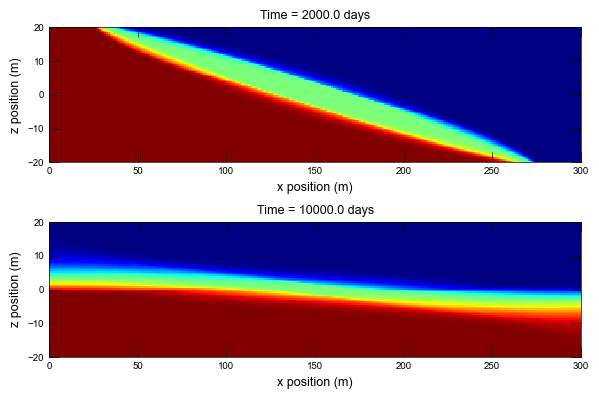

Creating velocity profile plot...


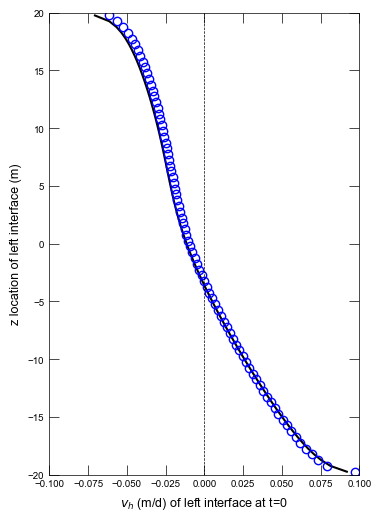

Creating animation...


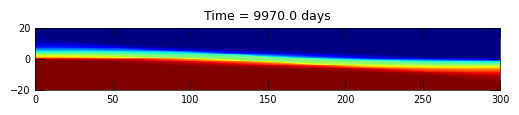

In [6]:
def scenario(idx, silent=True):
    sim = build_models(sim_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)